In [13]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import copy

In [17]:
df = pd.read_table("mushroom/mushroom.dat", sep = '\s+', header = None)

number of items:  119
number of flows:  186852
avg of S(x):  1570.18487394958
parameter phi:  0.0084
parameter epsilon should less than or equal phi


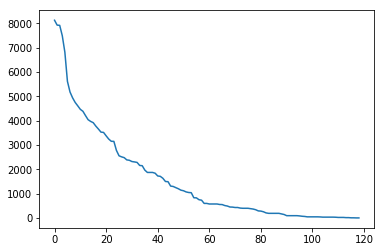

In [18]:
def viewData(df):
    d1 = dict()
    half = dict()
    count = 0
    half_total = len(df.index) / 2
    for line in df.values:
        count += 1
        for item in line:
            if item not in d1.keys():
                d1[item] = 0
            d1[item] += 1
        if count <= half_total:
            half = d1.copy()
    
    items = sorted(d1, key = d1.get, reverse = True)
    x = range(len(items))
    y = [d1[i] for i in items]
    plt.plot(x, y)
    print("number of items: ", len(items))
    print("number of flows: ", len(df.index) * len(df.columns))
    print("avg of S(x): ", len(df.index) * len(df.columns) / len(items))
    print("parameter phi: ", round(1 / len(items), 5))
    print("parameter epsilon should less than or equal phi")
    realHH = set()
    realHC = set()
    for i,n in d1.items():
        if n >= len(df.index) * len(df.columns) / len(items):
            realHH.add(i)
        if i in half.keys():
            if n - half[i] >= round(len(df.index) / 2) * len(df.columns) / len(items):
                realHC.add(i)
        else:
            if n >= round(len(df.index) / 2) * len(df.columns) / len(items):
                realHC.add(i)
    return d1
    print("sketch1 belongs to half of the stream")
    print("sketch2 belongs to total of the stream")
    return realHH, realHC

#realHH, realHC = viewData(df)
d1 = viewData(df)

In [19]:
def initSketch(sketch_width):  # 初始化PC*
    sketch = np.zeros(sketch_width).astype(np.uint8)
    return sketch

In [20]:
def update(sketch,item,s,alpha,beta):
    sketch_width = len(sketch)   # PC*的宽度m 
    c_alpha_upper = np.power(2,alpha)
    np.random.seed(item[0])
    h = np.random.choice(list(range(sketch_width)),size=s)
    np.random.seed()  # 重置随机数种子
    for i in h:  # 对s个VAC  
        c_alpha = sketch[i] // np.power(2,beta)
        c_beta  = sketch[i] - c_alpha * np.power(2,beta)
        pi = 1/np.power(2,c_beta)
        if np.random.random() < pi: 
            c_alpha += item[1]
            if c_alpha >= c_alpha_upper:
                c_alpha -= c_alpha_upper
                c_beta += 1
            sketch[i] = c_alpha * np.power(2,beta) + c_beta  
    return

In [21]:
def query(sketch,item,s,alpha,beta):
    nf = list()
    sketch_width = len(sketch)   # PC*的宽度m 
    c_alpha_upper = np.power(2,alpha)    
    np.random.seed(item[0])
    h = np.random.choice(list(range(sketch_width)),size=s)
    np.random.seed()  # 重置随机数种子
    for i in h: # 对s个VAC
        #np.random.seed(i+item[0])
        #hi = np.random.randint(sketch_width)
        c_alpha = sketch[i] // np.power(2,beta)
        c_beta  = sketch[i] - c_alpha  * np.power(2,beta)
        ns = (c_alpha_upper + c_alpha) * np.power(2,c_beta) - c_alpha_upper  # 当前VAC的估计
        nf.append(ns)
    return np.min(nf)

In [22]:
def processStream_HH(df, sketch, s, alpha, beta):
    for record in df.values:
        for i in record:
            item = (i,1)
            update(sketch,item,s,alpha,beta)
    return sketch

In [23]:
alpha = 3
beta = 5
m = 1024
s = 4

In [24]:
sketch = initSketch(m)

In [111]:
sketch = processStream_HH(df, sketch, s, alpha, beta)

In [112]:
sketch

array([ 0,  0,  0, ...,  0, 99,  0], dtype=uint8)

In [25]:
mx = [256,512,1024,2048,4096,8192]
res = list()
for m in mx:
    sketch = initSketch(m)
    sketch = processStream_HH(df, sketch, s, alpha, beta)
    su = 0
    total = 0
    for i,j in d1.items():
        su += 1
        temp = query(sketch,(i,1),s,alpha,beta)
        total += np.abs(temp-j)/j
    res.append(total/su)
res

[4.927422427619948,
 0.7023899509325782,
 0.17495081887961522,
 0.19073310995430345,
 0.19006582720572987,
 0.18935811807896855]

In [119]:
query(sketch,(23,1),s,alpha,beta)

[595 742  40 969]


3064

In [57]:
d1

{1: 3916,
 3: 3656,
 9: 2556,
 13: 2284,
 23: 3376,
 25: 256,
 34: 7914,
 36: 6812,
 38: 2512,
 40: 408,
 52: 3516,
 54: 1120,
 59: 5176,
 63: 4936,
 67: 4464,
 76: 4384,
 85: 8124,
 86: 7924,
 90: 7488,
 93: 3968,
 98: 1872,
 107: 1248,
 113: 368,
 2: 4208,
 14: 1072,
 26: 400,
 39: 5612,
 55: 556,
 99: 1968,
 108: 400,
 114: 2148,
 4: 452,
 15: 1040,
 27: 400,
 41: 1048,
 115: 292,
 10: 3244,
 16: 1840,
 24: 4748,
 28: 3528,
 37: 1312,
 53: 4608,
 94: 2776,
 109: 384,
 42: 752,
 43: 1492,
 110: 4040,
 44: 1202,
 11: 2320,
 64: 600,
 5: 32,
 111: 1712,
 6: 3152,
 56: 3776,
 116: 3148,
 57: 192,
 65: 284,
 117: 1144,
 100: 48,
 60: 552,
 45: 732,
 68: 576,
 77: 1872,
 69: 1872,
 78: 576,
 46: 492,
 17: 1500,
 29: 2160,
 61: 2372,
 66: 2304,
 70: 448,
 79: 432,
 95: 1296,
 101: 1632,
 71: 432,
 18: 144,
 30: 192,
 80: 512,
 19: 168,
 47: 96,
 58: 2480,
 72: 96,
 91: 600,
 102: 2388,
 112: 340,
 118: 192,
 31: 576,
 48: 1728,
 20: 16,
 96: 48,
 119: 832,
 103: 72,
 21: 44,
 7: 828,
 81: 

In [41]:
np.random.seed(3+5)
np.random.choice(list(range(m)),size=s)

array([451, 340, 361, 133, 986, 136, 851, 360])